## 引入CliffWalking-v0环境，及环境初探

In [1]:
import gym

env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境
print('状态空间：',env.observation_space)
print('动作空间：',env.action_space)
print('状态35执行[⬆️-0,➡️-1,⬇️-2,⬅️-3]动作后的四元组，分别表示(prob ,next_state, reward, down):')
env.P[35]

状态空间： Discrete(48)
动作空间： Discrete(4)
状态35执行[⬆️-0,➡️-1,⬇️-2,⬅️-3]动作后的四元组，分别表示(prob ,next_state, reward, down):


{0: [(1.0, 23, -1, False)],
 1: [(1.0, 35, -1, False)],
 2: [(1.0, 47, -1, True)],
 3: [(1.0, 34, -1, False)]}

In [2]:
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



## 1. Solving CliffWalking-v0 via Sarsa

In [3]:
import numpy as np
import random


def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,3)
    return action
    
def Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9, Q_table=None):
    '''
    Sarsa算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    if Q_table is None: Q = np.zeros( (env.nS, env.nA), dtype=np.float )
    else: Q = Q_table  # 方便后续作图，不做图的话可以忽略本行和Q_table形参
    sum_reward = 0
    for num in range(num_of_episode):
#         sum_reward = 0
        state = env.reset()  # Init S
        # 2.通过behavior policy采样初始state下的action
        action = select_action_behavior_policy(Q[state], epsilon)
        while True:
            # 3.执行action并观察R和next state
            next_state, reward, done, info = env.step(action)
            # 4.再次通过behavior policy采样next_action
            next_action = select_action_behavior_policy(Q[next_state], epsilon)
            # 5.更新Q(S,A),使用下一个状态-动作二元组更新
            Q[state][action] += alpha * (reward + gamma*Q[next_state][next_action]  - Q[state][action])
            sum_reward += reward
            if done: break
            state, action = next_state, next_action
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
#         if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    return Q, sum_reward

def get_optimal_policy(env, Q):
    '''从Q表中得到最优策略'''
    nS = Q.shape[0]
    policy = np.full(nS, 0)  # 初始化为全0元素
    for state in range(nS):
        action = np.argmax( Q[state] )
        next_state = env.P[state][action][0][1]
        policy[state] = action
    return policy
        
def print_policy(policy):
    print("\n【Sarsa Optimal Policy】：")
    for i, p in enumerate(policy):
        if i % 12 == 0 and i != 0:  print()
        if p == 0: print('⬆️', end=' ')
        elif p == 1: print('➡️', end=' ')
        elif p == 2: print('⬇️', end=' ')
        elif p == 3: print('⬅️', end=' ')
    
    
env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境  
# Q-learning学习出Q表
Q_table, _ = Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=2000, gamma=0.9)
# 通过训练好的Q表获取最优policy
policy = get_optimal_policy(env, Q_table)
# 打印最优policy
print_policy(policy)


【Sarsa Optimal Policy】：
➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ⬆️ ➡️ ⬅️ ➡️ ⬆️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ➡️ ⬆️ ⬆️ ⬆️ ⬆️ ➡️ ⬆️ ⬆️ ⬆️ ➡️ ⬇️ 
⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ 

## 2. Solving CliffWalking-v0 via Q-learning

In [4]:
import numpy as np
import random


def select_action_behavior_policy(action_value_set, epsilon):
    '''使用epsilon-greedy采样action'''
    prob = random.random()
    if prob > epsilon:  action = np.argmax(action_value_set)
    else:  action = random.randint(0,3)
    return action
    
def Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9, Q_table=None):
    '''
    Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    if Q_table is None: Q = np.zeros( (env.nS, env.nA), dtype=np.float )
    else: Q = Q_table
    sum_reward = 0
    for num in range(num_of_episode):
#         sum_reward = 0
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done, info = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*max( Q[next_state] ) - Q[state][action])
            sum_reward += reward
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        # if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    return Q, sum_reward

def get_optimal_policy(env, Q):
    '''从Q表中得到最优策略'''
    nS = Q.shape[0]
    policy = np.full(nS, 0)  # 初始化为全0元素
    for state in range(nS):
        action = np.argmax( Q[state] )
        next_state = env.P[state][action][0][1]
        policy[state] = action
    return policy
        
def print_policy(policy):
    print("\n【Q-learning Optimal Policy】：")
    for i, p in enumerate(policy):
        if i % 12 == 0 and i != 0:  print()
        if p == 0: print('⬆️', end=' ')
        elif p == 1: print('➡️', end=' ')
        elif p == 2: print('⬇️', end=' ')
        elif p == 3: print('⬅️', end=' ')
    
    
env = gym.make('CliffWalking-v0')   # 经典悬崖寻路环境  
# Q-learning学习出Q表
Q_table, _ = Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9)
# 通过训练好的Q表获取最优policy
policy = get_optimal_policy(env, Q_table)
# 打印最优policy
print_policy(policy)


【Q-learning Optimal Policy】：
⬆️ ➡️ ⬅️ ⬅️ ⬇️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬅️ ⬇️ 
⬇️ ⬇️ ➡️ ➡️ ➡️ ⬇️ ⬇️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ➡️ ⬇️ 
⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ ⬆️ 

- ## 两种算法Average reward对比

100%|██████████| 500/500 [00:15<00:00, 34.04it/s]


<IPython.core.display.Javascript object>


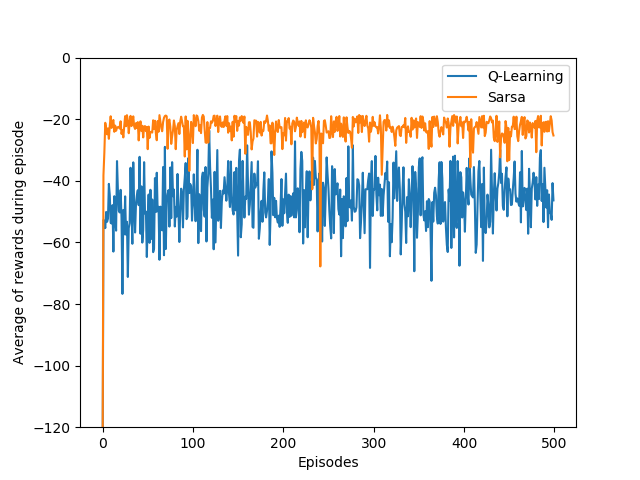

In [5]:
from tqdm import tqdm
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
import matplotlib as mpl
def plot_Sarsa_and_Q_learning(env, episodes=500, runs=50):
    '''绘图Q-learning'''
    Sarsa_table, Q_learning_table, Sarsa_average_reward, Q_learning_average_reward = None, None, [], []
    for i in tqdm(range(episodes)):
        Sarsa_table, Sarsa_sum_reward = Sarsa(env, alpha=0.2, epsilon_scope=[0.1,0.1,0.99], num_of_episode=runs, gamma=0.9, Q_table=Sarsa_table)
        Q_learning_table, Q_learning_sum_reward = Q_learning(env, alpha=0.2, epsilon_scope=[0.1,0.1,0.99], num_of_episode=runs, gamma=0.9, Q_table=Q_learning_table)
        Sarsa_average_reward.append(Sarsa_sum_reward/runs) 
        Q_learning_average_reward.append(Q_learning_sum_reward/runs) 
    plt.plot(Q_learning_average_reward, label='Q-Learning')
    plt.plot(Sarsa_average_reward, label='Sarsa')
    plt.xlabel('Episodes')
    plt.ylabel('Average of rewards during episode')
    plt.ylim([-120, 0])
    plt.legend()
    plt.show()
    plt.close()
        
env.reset()
plot_Sarsa_and_Q_learning(env, episodes=500, runs=60)

- ## 两种算法耗时对比

In [6]:
from timeit import repeat

consum_time = repeat( lambda:Q_learning(env, 0.2, [0.2,0.05,0.99], 1000, gamma=0.9), number=1, repeat=3 )
print('\nQ-learning在CliffWalking-v0任务上的最短耗时：%.4f秒' % ( min(consum_time) ) )
consum_time = repeat( lambda:Sarsa(env, 0.2, [0.2,0.05,0.99], 1000, gamma=0.9), number=1, repeat=3 )
print('\nSarsa在CliffWalking-v0任务上的最短耗时：%.4f秒' % ( min(consum_time) ) )


Q-learning在CliffWalking-v0任务上的最短耗时：0.3044秒

Sarsa在CliffWalking-v0任务上的最短耗时：0.2843秒


## 3. Double Q-learning

- 构建环境

In [148]:
import numpy as np

class Env():                   
    '''构造一个环境类'''        
    def __init__(self, mu, sigma, nB):  
        self.mu = mu
        self.sigma = sigma
        self.STATE_A = self.left = 0
        self.STATE_B = self.right = 1
        self.Terminal = 2
        self.nS = 3   # 加上Terminal即3个状态
        self.nA = 2
        self.nB = nB  # 状态B的动作数
        self.state = self.STATE_A 
        
    def reset(self):
        self.state = self.STATE_A
        return self.state
        
    def step(self, action):
        # A--left
        if self.state == self.STATE_A and action == self.left:
            self.state = self.STATE_B
            return self.state, 0, False  # next_state, reward, done
        # A--right
        elif self.state == self.STATE_A and action == self.right:
            self.state = self.Terminal
            return self.state, 0, True
        # B--all_actions
        elif self.state == self.STATE_B:
            self.state = self.Terminal
            reward = random.normalvariate(self.mu, self.sigma)
            return self.state, reward, True 

- 初始化Q表+采样动作函数定义

In [93]:
import numpy as np
import random

def init_Q_table(env):
    '''初始化Q表'''
    Q = {env.STATE_A:{action:0 for action in range(env.nA)},
         env.STATE_B:{action:0 for action in range(env.nB)},
         env.Terminal:{action:0 for action in range(env.nA)}}
    return Q

def select_action_behavior_policy(action_value_dict, epsilon):
    '''使用epsilon-greedy采样action'''
    if random.random() > epsilon:   
        max_keys = [key for key, value in action_value_dict.items() if value == max( action_value_dict.values() )]
        action = random.choice(max_keys)
    else:  
        # 从Q字典对应state中随机选取1个动作,由于返回list,因此通过[0]获取元素
        action = random.sample(action_value_dict.keys(), 1)[0]
    return action

- ### Q-learning算法实现

In [137]:
def Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])  
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=300, gamma=0.9)  
Q_table

{0: {0: -0.006068991206118512, 1: 0.0},
 1: {0: -0.4596504468843147,
  1: -0.1839760085136179,
  2: -0.553725092853021,
  3: -0.3716372006379332,
  4: -0.19214645343229309,
  5: -0.22353281507349992,
  6: -0.4764559360115985,
  7: -0.3410714345470353,
  8: -0.20344260000360292,
  9: -0.2999339187840022},
 2: {0: 0, 1: 0}}

- ### Double Q-learning算法实现

In [151]:
def get_Q1_add_Q2(Q1_state_dict, Q2_state_dict):
    '''返回Q1[state]+Q2[state]'''
    return {action: Q1_value + Q2_state_dict[action] for action, Q1_value in Q1_state_dict.items()}

def double_Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    双Q学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q1表和Q2表
    Q1 = init_Q_table(env)
    Q2 = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            add_Q1_Q2_state = get_Q1_add_Q2(Q1[state], Q1[state])
            action = select_action_behavior_policy(add_Q1_Q2_state, epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            if random.random() >= 0.5:
                # 从Q1表中的下一步state找出状态价值最高对应的action视为Q1[state]的最优动作
                A1 = random.choice( [action for action, value in Q1[next_state].items() if value == max( Q1[next_state].values() )] )
                # 将Q1[state]得到的最优动作A1代入到Q2[state][A1]中的值作为Q1[state]的更新
                Q1[state][action] += alpha * (reward + gamma*Q2[next_state][A1] - Q1[state][action])
            else:
                A2 = random.choice( [action for action, value in Q2[next_state].items() if value == max( Q2[next_state].values() )] )
                Q2[state][action] += alpha * (reward + gamma*Q1[next_state][A2] - Q2[state][action])
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q1


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = double_Q_learning(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=300, gamma=0.9)  
Q_table

{0: {0: -0.16226898361839223, 1: 0.0},
 1: {0: -0.056267851050891715,
  1: 0,
  2: -0.32139134492161914,
  3: -0.05068701861944711,
  4: -0.1006468887094128,
  5: 0,
  6: 0,
  7: 0,
  8: -0.1759164152792878,
  9: 0.08412965690762401},
 2: {0: 0, 1: 0}}

- ### Action Distribution思想实现

In [124]:
def Action_Distribution(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    按当前state的动作分布选择动作,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*random.choice(list( Q[next_state].values() )) - Q[state][action])
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Action_Distribution(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=300, gamma=0.9)  
Q_table

{0: {0: -0.10846670412335989, 1: 0.0},
 1: {0: -0.2889859321387325,
  1: 0,
  2: -0.07030315399869486,
  3: -0.13271090492752532,
  4: -0.06324929139620761,
  5: -0.23777070612079917,
  6: -0.317302369732366,
  7: 0.18969274275474823,
  8: -0.005707044700954483,
  9: -0.30509848521912447},
 2: {0: 0, 1: 0}}

- ### Expected Sarsa算法实现

In [125]:
def Expected_Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    期望Sarsa算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q表
    Q = init_Q_table(env)
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            action = select_action_behavior_policy(Q[state], epsilon)
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            Q[state][action] += alpha * (reward + gamma*sum( Q[next_state].values() ) / len(Q[next_state]) - Q[state][action])  
            if done: break
            state = next_state
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
    return Q


env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table = Expected_Sarsa(env, alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=300, gamma=0.9)  
Q_table

{0: {0: -0.024348735928867105, 1: 0.0},
 1: {0: 0,
  1: -0.3474740332148313,
  2: 0,
  3: -0.16249983192278689,
  4: 0,
  5: 0,
  6: -0.039890089360632014,
  7: -0.06802878927162603,
  8: -0.08032721451540115,
  9: 0},
 2: {0: 0, 1: 0}}

## TD-Learing Summary

In [104]:
def TD_learning(env, method='Q-Learning', alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=1000, gamma=0.9):
    '''
    TD学习算法,返回Q表和估计的最优策略
    其中epsilon_scope由高到低衰减,从左到右分别是[最高值,最低值,衰减因子]
    '''
    epsilon = epsilon_scope[0]
    # 1. 初始化Q1表和Q2表
    Q = init_Q_table(env)
    if method == 'Double-Q':
        Q2 = init_Q_table(env)
    bool_A_left = np.zeros(num_of_episode)
    Aleft_Q_values = []
    B_max_Q_values = []
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        while True:
            # 2.通过behavior policy采样action
            if method == 'Double-Q':
                add_Q1_Q2_state = {action: Q1_value + Q2[state][action] for action, Q1_value in Q[state].items()}
                action = select_action_behavior_policy(add_Q1_Q2_state, epsilon)
            else: action = select_action_behavior_policy(Q[state], epsilon)
            if state == env.STATE_A and action == env.left:  
                bool_A_left[int(num)] += 1
            # 3.执行action并观察R和next state
            next_state, reward, done = env.step(action)
            # 4.更新Q(S,A),使用max操作更新
            if method == 'Q-Learning':
                Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])
            elif method == 'Expected_Sarsa':
                Q[state][action] += alpha * (reward + gamma*sum( Q[next_state].values() ) / len(Q[next_state]) - Q[state][action])  
            elif method == 'Action_Distribution':
                Q[state][action] += alpha * (reward + gamma*random.choice(list( Q[next_state].values() )) - Q[state][action])
            elif method == 'Double-Q':
                if random.random() >= 0.5:
                    # 从Q1表中的下一步state找出状态价值最高对应的action视为Q1[state]的最优动作
                    A1 = random.choice( [action for action, value in Q[next_state].items() if value == max( Q[next_state].values() )] )
                    # 将Q1[state]得到的最优动作A1代入到Q2[state][A1]中的值作为Q1[state]的更新
                    Q[state][action] += alpha * (reward + gamma*Q2[next_state][A1] - Q[state][action])
                else:
                    A2 = random.choice( [action for action, value in Q2[next_state].items() if value == max( Q2[next_state].values() )] )
                    Q2[state][action] += alpha * (reward + gamma*Q[next_state][A2] - Q2[state][action])
            if done: break
            state = next_state
            
        Aleft_Q_values.append(Q[env.STATE_A][env.left])
        B_max_Q_values.append(max(Q[env.STATE_B].values()))
        # 对epsilon进行衰减
        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        # if num % 20 == 0:  print("Episode: {}, Score: {}".format(num, sum_reward))
    return Q, bool_A_left, Aleft_Q_values, B_max_Q_values


# method = ['Q-Learning', 'Expected_Sarsa', 'Action_Distribution', 'Double-Q']
env = Env(-0.1, 1, 10)   
# Q-learning学习出Q表
Q_table, _, _, _ = TD_learning(env, method='Double-Q', alpha=0.2, epsilon_scope=[0.2,0.05,0.99], num_of_episode=300, gamma=0.9)  
Q_table

{0: {0: -0.26395946307558565, 1: 0.0},
 1: {0: -0.11655926437980045,
  1: 0.4588280209916919,
  2: 0,
  3: 0,
  4: -0.35397781929704086,
  5: 0,
  6: 0.2782146704992834,
  7: 0,
  8: 0,
  9: 0},
 2: {0: 0, 1: 0}}

100%|██████████| 1000/1000 [00:09<00:00, 107.57it/s]


<IPython.core.display.Javascript object>


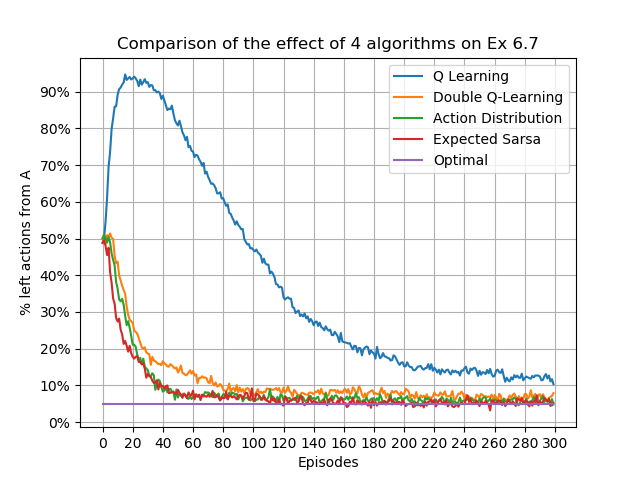

In [147]:
def show_figure(prob_Q_A_left, prob_E_A_left, prob_AD_A_left, prob_Q2_A_left):
    import matplotlib.pyplot as plt
    plt.ylabel('% left actions from A')
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,301, 20)
    y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    plt.plot(range(300), prob_Q_A_left, '-',label='Q Learning')
    plt.plot(range(300), prob_E_A_left, '-',label='Double Q-Learning')
    plt.plot(range(300), prob_AD_A_left, '-',label='Action Distribution')
    plt.plot(range(300), prob_Q2_A_left, '-',label='Expected Sarsa')
    plt.plot(np.ones(300) * 0.05, label='Optimal')
    plt.title('Comparison of the effect of 4 algorithms on Ex 6.7')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    
    
total_num = 1000

A_Q_lst, B_Q_lst = np.zeros( (total_num, 300) ) ,np.zeros( (total_num, 300) )
A_Q2_lst, B_Q2_lst = np.zeros( (total_num, 300) ) ,np.zeros( (total_num, 300) )
A_AD_lst, B_AD_lst = np.zeros( (total_num, 300) ) ,np.zeros( (total_num, 300) )
A_E_lst, B_E_lst = np.zeros( (total_num, 300) ) ,np.zeros( (total_num, 300) )

prob_Q_A_left = np.zeros( (total_num, 300) )
prob_Q2_A_left = np.zeros( (total_num, 300) )
prob_AD_A_left = np.zeros( (total_num, 300) )
prob_E_A_left = np.zeros( (total_num, 300) )
# 计算在STATE_A下采样动作left的概率

alpha = 0.1
start_epsilon = 0.1
gamma = 0.9
num_of_episode = 300

for num in tqdm(range(total_num)):
    _, A_left1, A_Q1, B_Q1 = TD_learning(env, 'Q-Learning', alpha, epsilon_scope=[start_epsilon,0.05,1], num_of_episode=num_of_episode, gamma=gamma)
    _, A_left2, A_Q2, B_Q2 = TD_learning(env, 'Double-Q', alpha, epsilon_scope=[start_epsilon,0.05,1], num_of_episode=num_of_episode, gamma=gamma)
    _, A_left3, A_Q3, B_Q3 = TD_learning(env, 'Action_Distribution', alpha, epsilon_scope=[start_epsilon,0.05,1], num_of_episode=num_of_episode, gamma=gamma)
    _, A_left4, A_Q4, B_Q4 = TD_learning(env, 'Expected_Sarsa', alpha, epsilon_scope=[start_epsilon,0.05,1], num_of_episode=num_of_episode, gamma=gamma)
    
    prob_Q_A_left[int(num)] = A_left1
    prob_Q2_A_left[int(num)] = A_left2
    prob_AD_A_left[int(num)] = A_left3
    prob_E_A_left[int(num)] = A_left4
    
    A_Q_lst[int(num)], B_Q_lst[int(num)] = A_Q1, B_Q1
    A_Q2_lst[int(num)], B_Q2_lst[int(num)] = A_Q2, B_Q2
    A_AD_lst[int(num)], B_AD_lst[int(num)] = A_Q3, B_Q3
    A_E_lst[int(num)], B_E_lst[int(num)] = A_Q4, B_Q4
    
a = prob_Q_A_left.mean(axis=0)
b = prob_Q2_A_left.mean(axis=0)
c = prob_AD_A_left.mean(axis=0)
d = prob_E_A_left.mean(axis=0)

show_figure(a, b, c, d)

- 实验绘图

注意有两种画图方式
- 外层循环是300episodes,然后每个episode训练1w次，得出%left的概率

【问题1】每个episode下的Q表相同，如果某一步更新是left>right，则会出现抖动，Ex.100次episode之后的抖动

【问题2】从图中可以看出，前20次left的频率都在90%左右，这是因为计算某个episode下某个动作的频率实际上是计算$\epsilon-greedy$选择left的概率，由于一开始$\epsilon=0.2$，所以当Q表中left>right时，选择最优+非最优均是left的概率为$1-\epsilon + \frac{\epsilon}{|A|}=0.8+ 0.2/2=0.9$

此图能看出什么？从此图中可以看出在300次episodes中有多少次以及训练到什么程度时Q表中的left>right(>0.8)，以及有多少次是right<left，还有$\epsilon$的衰减过程(随着episode的增加，峰值也在增加)

【问题3】采样数据时，直接使用argmax(Q),容易在初期出现极端值，因为初期的Q表是全0的空表，所以该操作会导致每次选取第一个Q值，使得在画图初期出现极端值,应该加一个判断，若每个值都相等，则等概率随机选取动作